In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from scipy.stats import zscore

# xgboost

In [130]:
train = pd.read_csv('C:\\Users\\odoru\\SIGNATE_time_deposit_account\\train.csv')
test = pd.read_csv('C:\\Users\\odoru\\SIGNATE_time_deposit_account\\test.csv')
submit = pd.read_csv('C:\\Users\\odoru\\SIGNATE_time_deposit_account\\head_submit_sample.csv')

In [131]:
# jobのunknownの処理
test.replace({'job': {'unknown':'blue-collar'}}, inplace=True)

In [132]:
#score列の作成
train['score'] = np.zeros(train.shape[0])


#個人ローン
#学習データ
loan_none = train.loc[train['loan'] == 'no']
index = loan_none.index.values
index = list(index)

for i in index:
    train.iloc[i,18] = 1
    


#住宅ローン
housing_none = train.loc[train['housing'] == 'no']
index = housing_none.index.values
index = list(index)

score_values = housing_none['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['housing']=='no','score'] = i



#債務不履行
default = train.loc[train['default'] == 'yes']


score_values = default['score'].values
score_values = score_values - 3
score_values = list(score_values)

for i in score_values:
    train.loc[train['default']=='yes','score'] = i





#経営者
management = train.loc[train['job'] == 'management']


score_values = management['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['job']=='management','score'] = i
    


#管理者
admin = train.loc[train['job'] == 'admin.']


score_values = admin['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['job']=='admin.','score'] = i
    



#学生
student = train.loc[train['job'] == 'student']


score_values = student['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['job']=='student','score'] = i
    




#失業者
unemployed = train.loc[train['job'] == 'unemployed']


score_values = unemployed['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['job']=='unemployed','score'] = i
    
train.loc[train['job'] == 'unemployed']




#定年退職者
retired = train.loc[train['job'] == 'retired']


score_values = retired['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['job']=='retired','score'] = i
    

In [133]:
#テストデータ
#score列の作成
test['score'] = np.zeros(test.shape[0])

#個人ローン
loan_none = test.loc[test['loan'] == 'no']
index = loan_none.index.values
index = list(index)

for i in index:
    test.iloc[i,17] = 1



#住宅ローン
housing_none = test.loc[test['housing'] == 'no']

score_values = housing_none['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['housing']=='no','score'] = i



#債務不履行
default = test.loc[test['default'] == 'yes']


score_values = default['score'].values
score_values = score_values - 3
score_values = list(score_values)

for i in score_values:
    test.loc[test['default']=='yes','score'] = i





#経営者
management = test.loc[test['job'] == 'management']


score_values = management['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['job']=='management','score'] = i
    


#管理者
admin = test.loc[test['job'] == 'admin.']


score_values = admin['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['job']=='admin.','score'] = i
    



#学生
student = test.loc[test['job'] == 'student']


score_values = student['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['job']=='student','score'] = i
    




#失業者
unemployed = test.loc[test['job'] == 'unemployed']


score_values = unemployed['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['job']=='unemployed','score'] = i
    



#定年退職者
retired = test.loc[test['job'] == 'retired']


score_values = retired['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['job']=='retired','score'] = i

In [134]:
cat_cols = ['job','marital','education','default','housing','loan','contact','month']
#LabelEncording
for c in cat_cols:
    le = LabelEncoder()
    le.fit(train[c])
    train[c] = le.transform(train[c])
    test[c] = le.transform(test[c])

# poutcomeのunknownの作成

In [135]:
#unknownとunknownでない奴の分割
un_df =  train.loc[train['poutcome'] == 'unknown']
df = train.loc[train['poutcome'] != 'unknown']

In [136]:
un_df.drop(['poutcome','y'], axis = 1, inplace =True)

C:\Users\odoru\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [137]:
df.drop(['y'], axis = 1, inplace =True)

In [138]:
un_df =  train.loc[train['poutcome'] == 'unknown']
df = train.loc[train['poutcome'] != 'unknown']

un_df.drop(['poutcome','y'], axis = 1, inplace =True)
df = df.drop(['y'], axis = 1)

#df_poutcome = pd.get_dummies(df['poutcome'])
#df = df.drop(['poutcome'], axis = 1)

#df = pd.concat([df,df_poutcome], axis=1)

In [139]:
df.poutcome.value_counts()

failure    2717
other       826
success     458
Name: poutcome, dtype: int64

In [140]:
#カラム一つのやつ


le = LabelEncoder()
le.fit(df['poutcome'])
df['poutcome'] = le.transform(df['poutcome'])
df_x = df.iloc[:,1:16]
df_x['score'] = df['score']
df_y = df['poutcome']
df_test_x = un_df.drop(['id'] ,axis = 1)

In [141]:
df.poutcome.value_counts()

0    2717
1     826
2     458
Name: poutcome, dtype: int64

# トレーニングデータのunknownの予測

# カラムを分けるやつは学習データ数が少ないため精度が全くでないため不採用

In [142]:
#カラムを分けるやつ


#df_x = df.iloc[:,1:17]
#df_y_f = df.loc[:,['failure']]
#df_y_o = df.loc[:,['other']]
#df_y_s = df.loc[:,['success']]
#df_test_x = un_df.drop(['id'] ,axis = 1)

#hold out 法
#kf = KFold(n_splits=4, shuffle=True, random_state=71)
#tr_idx, va_idx = list(kf.split(df_x))[0]
#tr_x,va_x = df_x.iloc[tr_idx], df_x.iloc[va_idx]
#tr_y,va_y = df_y_s.iloc[tr_idx], df_y_s.iloc[va_idx] 

#d_train = xgb.DMatrix(tr_x, label=tr_y)
#d_valid = xgb.DMatrix(va_x, label=va_y)

#params = {'objective':'binary:logistic','silent':1, 'random_state':71, 'eta':0.1}

#num_round = 500

#watchilist = [(d_train,'train'),(d_valid,'eval')]

#model = xgb.train(params,d_train, num_round, evals = watchilist, early_stopping_rounds=20 )

#val_pred = model.predict(d_valid, ntree_limit = model.best_ntree_limit)

#score = log_loss(va_y,val_pred)
#print(score)

In [143]:
#a = np.where(val_pred< 0.7, 1,0 )
#print(a)
#accuracy = accuracy_score(va_y, a)
#print(accuracy)

In [144]:
#hold out 法
kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(df_x))[0]
tr_x,va_x = df_x.iloc[tr_idx], df_x.iloc[va_idx]
tr_y,va_y = df_y.iloc[tr_idx], df_y.iloc[va_idx] 


d_train = xgb.DMatrix(tr_x, label=tr_y)
d_valid = xgb.DMatrix(va_x, label=va_y)

params = {'objective':'multi:softmax','num_class' : 3 ,'silent':1, 'random_state':71, 'eta':0.1}

num_round = 500

watchilist = [(d_train,'train'),(d_valid,'eval')]

model = xgb.train(params,d_train, num_round, evals = watchilist, early_stopping_rounds=20 )

val_pred = model.predict(d_valid, ntree_limit = model.best_ntree_limit)

accuracy = accuracy_score(va_y, val_pred)
print(accuracy)

[19:12:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.25100	eval-merror:0.29371
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 20 rounds.
[1]	train-merror:0.25233	eval-merror:0.29371
[2]	train-merror:0.24833	eval-merror:0.29171
[3]	train-merror:0.24600	eval-merror:0.28871
[4]	train-merror:0.24533	eval-merror:0.29570
[5]	train-merror:0.24200	eval-merror:0.29071
[6]	train-merror:0.23500	eval-merror:0.28871
[7]	train-merror:0.23300	eval-merror:0.28372
[8]	train-merror:0.22700	eval-merror:0.28372
[9]	train-merror:0.22767	eval-merror:0.27872
[10]	train-merror:0

# unknownが入っているトレーニングデータの作成

In [145]:
d_test = xgb.DMatrix(df_test_x)

test_pred = model.predict(d_test, ntree_limit = model.best_ntree_limit)

In [146]:
# トレーニングデータの完成
df_test_x['poutcome'] = test_pred

df_concat_train = pd.concat([df_x, df_y], axis = 1)
df_concat_train = pd.concat([df_concat_train, df_test_x], axis = 0)
df_concat_train = df_concat_train.sort_index()

In [147]:
a = pd.get_dummies(df_concat_train['poutcome'])

In [148]:
a.columns = ['failure','other','success']
a

,failure,other,success
0,0,1,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
27095,1,0,0
27096,1,0,0
27097,0,1,0
27098,1,0,0


In [151]:
a.to_csv('xgboost_poutcome.csv',index=False)

# unknownが入っているテストデータの作成

In [89]:
test_x = test.drop(['poutcome','id'],axis=1)
d_test = xgb.DMatrix(test_x)
test_pred = model.predict(d_test, ntree_limit = model.best_ntree_limit)
test_x['poutcome'] = test_pred

# unknownが入ったデータでのyの予測

In [90]:
train_x = df_concat_train
train_y = train['y']
test = test_x

In [91]:
#hold out 法
kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x,va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y,va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx] 


d_train = xgb.DMatrix(tr_x, label=tr_y)
d_valid = xgb.DMatrix(va_x, label=va_y)

params = {'objective':'binary:logistic','silent':1, 'random_state':71, 'eta':0.1}

num_round = 500

watchilist = [(d_train,'train'),(d_valid,'eval')]

model = xgb.train(params,d_train, num_round, evals = watchilist, early_stopping_rounds=20 )

val_pred = model.predict(d_valid, ntree_limit = model.best_ntree_limit)

score = log_loss(va_y,val_pred)
print(score)

[11:09:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-error:0.06809	eval-error:0.06937
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[1]	train-error:0.06731	eval-error:0.06849
[2]	train-error:0.06667	eval-error:0.06834
[3]	train-error:0.06677	eval-error:0.06819
[4]	train-error:0.06637	eval-error:0.06731
[5]	train-error:0.06667	eval-error:0.06775
[6]	train-error:0.06637	eval-error:0.06686
[7]	train-error:0.06667	eval-error:0.06731
[8]	train-error:0.06657	eval-error:0.06745
[9]	train-error:0.06657	eval-error:0.06716
[10]	train-error:0.06681	eval-error:0.067

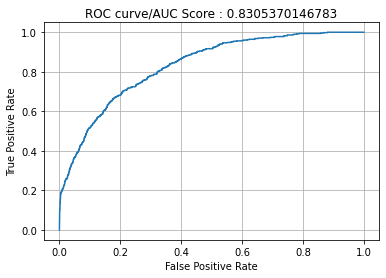

In [92]:
fig = plt.figure()

fpr,tpr,thresholds = roc_curve(va_y,val_pred)
auc_score = roc_auc_score(va_y,val_pred)

plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve/AUC Score : {auc_score}')

plt.grid(True)

In [22]:
# 重要度の上位を出力する
fscore = model.get_score(importance_type ='total_gain')
fscore = sorted([ (k, v ) for k, v in fscore.items()], key = lambda tpl: [1], reverse=True)
print('xgboost immportance')
print(fscore[:5])

xgboost immportance
[('poutcome', 2992.931366090501), ('housing', 2241.219695170499), ('month', 2562.036436179735), ('duration', 2575.0864239738), ('age', 1759.2593878218001)]


In [23]:
#データのｙを求める
d_test = xgb.DMatrix(test_x)


test_pred = model.predict(d_test, ntree_limit=model.best_ntree_limit)

In [ ]:
# 出力用のデータの作成
id = test['id']
test_pred = pd.Series(test_pred)
pred = test_pred

submit = pd.concat([id,pred], axis=1)
submit.columns = ['id', 'y']
submit

In [ ]:
# 提出用
submit.to_csv('xgboost.csv',index=False,header=False)

In [ ]:
#アンサンブル用
submit.to_csv('xgboost.csv',index = False)